#**LOAD BTC DATASET**

In [ ]:
from google.colab import files
#uploaded = files.upload()
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('/content/BTC-USD.csv', index_col = 0, parse_dates = True, na_values = 0).dropna()



data = data[:data.shape[0]-60] # To cut the data and try earlier test timeframes


In [ ]:
data.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-04-10,7303.815430,7303.815430,6802.475098,6865.493164,6865.493164,4.362284e+10
2020-04-11,6867.440430,6926.069824,6789.920898,6859.083008,6859.083008,3.122209e+10
2020-04-12,6858.067871,7119.947266,6811.078125,6971.091797,6971.091797,3.575957e+10
2020-04-13,6965.616699,6965.616699,6668.259766,6845.037598,6845.037598,3.861931e+10
2020-04-14,6843.281738,6958.557129,6793.821289,6842.427734,6842.427734,3.411043e+10


# **CREATE NEW FEATURES**

In [ ]:
'''
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
'''

'\n!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz\n!tar -xzvf ta-lib-0.4.0-src.tar.gz\n%cd ta-lib\n!./configure --prefix=/usr\n!make\n!make install\n!pip install Ta-Lib\n'

In [ ]:
import talib as ta
data['RSI5'] = ta.RSI(data['Close'], timeperiod=5)
data['RSI14'] = ta.RSI(data['Close'], timeperiod=14)
data.dropna(inplace=True)
data.head(50)

,Open,High,Low,Close,Adj Close,Volume,RSI5,RSI14
Date,,,,,,,,
2014-10-01,387.427002,391.378998,380.779999,383.614990,383.614990,26229400.0,32.500956,31.461697
2014-10-02,383.988007,385.497009,372.946014,375.071991,375.071991,21777700.0,27.034893,30.070294
2014-10-03,375.181000,377.695007,357.859009,359.511993,359.511993,30901200.0,19.549391,27.670002
2014-10-04,359.891998,364.487000,325.885986,328.865997,328.865997,47236500.0,11.625027,23.663588
2014-10-05,328.915985,341.800995,289.295990,320.510010,320.510010,83308096.0,10.213926,22.698531
2014-10-06,320.389008,345.134003,302.559998,330.079010,330.079010,79011800.0,23.505411,26.400241
2014-10-07,330.584015,339.247009,320.481995,336.187012,336.187012,49199900.0,31.586152,28.745779
2014-10-08,336.115997,354.364014,327.187988,352.940002,352.940002,54736300.0,49.776181,34.876115
2014-10-09,352.747986,382.726013,347.687012,365.026001,365.026001,83641104.0,59.489311,38.956384


#**DATA SCALING**



In [ ]:
max_=data[['Open','High','Low','Close']].max().max()
min_=data[['Open','High','Low','Close']].min().min()

scl=MinMaxScaler()

X1=(data[['Open','High','Low','Close']]-min_)/(max_-min_)
X2=scl.fit_transform(data[['Volume']].values.reshape(-1,1))
#X3=data['RSI5']/100
X3 = scl.fit_transform(data[['RSI5']].values.reshape(-1,1))
#X4=data['RSI14']/100
X4 = scl.fit_transform(data[['RSI14']].values.reshape(-1,1))
X1=np.array(X1)

data=data.assign(Open=X1[:,0])
data=data.assign(High=X1[:,1])
data=data.assign(Low=X1[:,2])
data=data.assign(Close=X1[:,3])
data=data.assign(Volume=X2[:,0])
data=data.assign(RSI5=X3)
data=data.assign(RSI14=X4)
data.head()

,Open,High,Low,Close,Adj Close,Volume,RSI5,RSI14
Date,,,,,,,,
2014-10-01,0.010841,0.011039,0.010507,0.010649,383.614990,0.000274,0.302240,0.255285
2014-10-02,0.010668,0.010744,0.010114,0.010220,375.071991,0.000214,0.245481,0.238796
2014-10-03,0.010226,0.010352,0.009356,0.009439,359.511993,0.000337,0.167752,0.210350
2014-10-04,0.009458,0.009689,0.007751,0.007900,328.865997,0.000557,0.085466,0.162871
2014-10-05,0.007903,0.008550,0.005914,0.007481,320.510010,0.001044,0.070813,0.151434


In [ ]:
data.shape

(2023, 8)

#**DEFINE INPUTS AND TARGET FEATURES**

In [ ]:
X=data[['Open','High','Low','Close','Volume', 'RSI5', 'RSI14']]
y=data.Close.shift(-1)

In [ ]:
timestep=20
X_list=[]
y_list=[]
for i in range(timestep,len(X)):
    X_list.append(np.array(X.iloc[i-timestep:i]))
    y_list.append(y.iloc[i])

test_size=60
X_train=np.array(X_list)[:-test_size]
y_train=np.array(y_list)[:-test_size]
X_test=np.array(X_list)[-test_size:]
y_test=np.array(y_list)[-test_size:]

X_train

array([[[1.08405731e-02, 1.10389915e-02, 1.05068462e-02, ...,
         2.73966218e-04, 3.02239759e-01, 2.55285067e-01],
        [1.06679111e-02, 1.07436737e-02, 1.01135243e-02, ...,
         2.13930500e-04, 2.45480548e-01, 2.38795722e-01],
        [1.02257365e-02, 1.03519576e-02, 9.35604908e-03, ...,
         3.36970210e-04, 1.67751626e-01, 2.10350174e-01],
        ...,
        [1.06673089e-02, 1.12287238e-02, 1.04160219e-02, ...,
         7.42031877e-05, 6.26567657e-01, 4.61028881e-01],
        [1.10327156e-02, 1.11675216e-02, 1.07918722e-02, ...,
         0.00000000e+00, 5.90518552e-01, 4.53357553e-01],
        [1.09311461e-02, 1.09739741e-02, 1.03799233e-02, ...,
         1.41662961e-04, 4.69141866e-01, 4.25930523e-01]],

       [[1.06679111e-02, 1.07436737e-02, 1.01135243e-02, ...,
         2.13930500e-04, 2.45480548e-01, 2.38795722e-01],
        [1.02257365e-02, 1.03519576e-02, 9.35604908e-03, ...,
         3.36970210e-04, 1.67751626e-01, 2.10350174e-01],
        [9.45811962e-03, 

#**CREATE RNN MODEL**

In [ ]:
from keras.layers import SimpleRNN
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

dropout_ratio=0.2
model=Sequential()
model.add(SimpleRNN(timestep,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(Dense(32))
model.add(Dropout(dropout_ratio))
model.add(Dense(64))
model.add(Dropout(dropout_ratio))
model.add(Dense(128))
model.add(Dropout(dropout_ratio))
model.add(Dense(256))
model.add(Dropout(dropout_ratio))
model.add(Dense(512))
model.add(Dropout(dropout_ratio))
model.add(Dense(1024))
model.add(Dropout(dropout_ratio))
model.add(Dense(2048))
model.add(Dropout(dropout_ratio))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_10 (SimpleRNN)    (None, 20)                560       
_________________________________________________________________
dense_80 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_70 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_81 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_71 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_82 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_72 (Dropout)         (None, 128)             

#**FIT MODEL AND SAVE BEST WEIGHTS**

In [ ]:
filepath="weights-btc.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
history = model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=1, validation_split=0.2,callbacks=[checkpoint])

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 1.2415
Epoch 00001: val_loss improved from inf to 0.04933, saving model to weights-btc.hdf5
32/32 [==============================] - 2s 57ms/step - loss: 1.2415 - val_loss: 0.0493
Epoch 2/100
31/32 [============================>.] - ETA: 0s - loss: 0.0694
Epoch 00002: val_loss improved from 0.04933 to 0.00345, saving model to weights-btc.hdf5
32/32 [==============================] - 2s 53ms/step - loss: 0.0695 - val_loss: 0.0035
Epoch 3/100
31/32 [============================>.] - ETA: 0s - loss: 0.0314
Epoch 00003: val_loss improved from 0.00345 to 0.00342, saving model to weights-btc.hdf5
32/32 [==============================] - 2s 53ms/step - loss: 0.0315 - val_loss: 0.0034
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 0.0247
Epoch 00004: val_loss improved from 0.00342 to 0.00236, saving model to weights-btc.hdf5
32/32 [==============================] - 2s 53ms/step - loss: 0.0247 - val_loss:

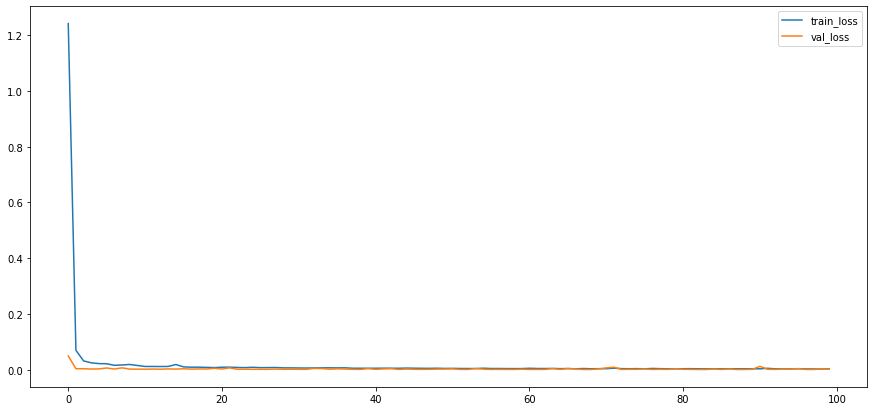

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["train_loss", "val_loss"])

#**TEST PREDICTIONS**

In [ ]:
model.load_weights(filepath)

descale = (max_-min_)+min_

predict_close=[]
predict_close=np.reshape(model.predict(X_test) * descale,(1,-1))
predict_close=predict_close[0]
performance=pd.DataFrame([predict_close, y_test * descale])
performance=performance.T
performance.columns=['Predicted','Actual']
performance.tail()

,Predicted,Actual
55,8967.540039,6745.159868
56,7641.438965,6858.133168
57,7202.307617,6730.993513
58,7319.507812,6728.361175
59,7289.207520,NaN


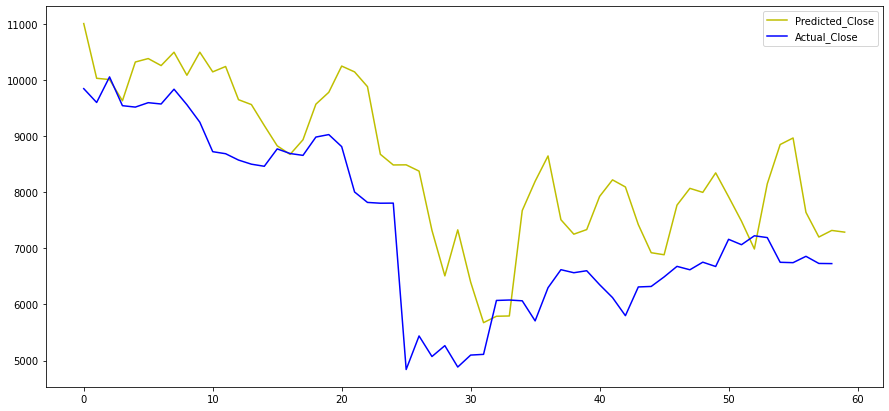

In [ ]:
Spread = []
Spread = performance.Actual - performance.Predicted

plt.figure(figsize=(15,7))
plt.plot(performance.Predicted,c='y')
plt.plot(performance.Actual,c='b')
plt.legend(['Predicted_Close','Actual_Close'])
plt.show()

#**MEASURE MODEL PERFORMANCE**

Text(0.5, 1.0, 'Accumulated profit in 60 days: -2260.86 (-22.96%)')

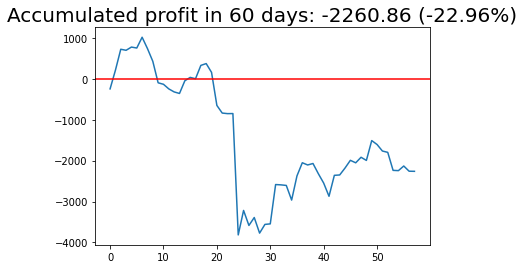

In [ ]:
# TEST FOR PROFIT

# TODO: This part of the cold is recycled from old code, so naming conventions must be matched

# If next predicted price is higher than actual price, buy.
# Otherwise, stay out of the market.

current_position = 0

sample = performance

for idx in range(0, 59):
  if sample.loc[idx, 'Actual'] < sample.loc[idx+1, 'Predicted']:
    current_position = 1
  else:
    current_position = -1   # Can also be -1 if we want to try a Long/Short strategy
  sample.loc[idx,'Position'] = current_position
  sample.loc[idx, 'Profit'] = current_position*(sample.loc[idx+1, 'Actual'] - sample.loc[idx, 'Actual'])
  
#sample.profit.plot()
#plt.axhline(y=0, color='red')

plt.title("Profit per day over history",fontsize=20)
sample['Wealth'] = sample['Profit'].cumsum()
sample.Wealth.plot()
plt.axhline(y=0, color='red')
plt.title("Accumulated profit in {:.0f} days: {:.2f} ({:.2f}%)".format(
    len(sample.index),
    sample.loc[sample.index[-3], 'Wealth'],
    sample.loc[sample.index[-3], 'Wealth']/sample.loc[sample.index[0], 'Actual']*100),
    fontsize=20)

In [ ]:
print("Market profit: {:.2f}%".format((sample.loc[sample.index[-3], 'Actual']/sample.loc[0, 'Actual']-1)*100))

Market profit: -31.64%


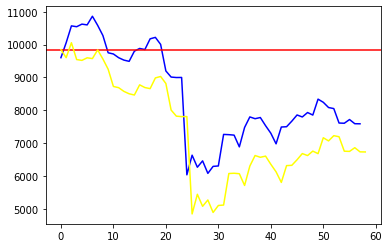

In [ ]:
# Visualize Model vs Market (Buy&Hold) side by side

sample['TotalWealth'] = sample['Wealth'] + sample.Actual[0]
sample.TotalWealth.plot(color="blue")
plt.axhline(y=sample.Actual[0], color='red')
sample.Actual.plot(color='yellow')

In [ ]:
performance.head(50)

,Predicted,Actual,Position,Profit,Wealth,TotalWealth
0,11006.961914,9846.992374,1.0,-246.394612,-246.394612,9600.597762
1,10031.654297,9600.597762,1.0,455.744438,209.349826,10056.342199
2,10009.218750,10056.342199,-1.0,512.989023,722.338849,10569.331222
3,9631.027344,9543.353177,1.0,-25.125643,697.213205,10544.205579
4,10321.965820,9518.227533,1.0,78.637186,775.850391,10622.842764
5,10383.286133,9596.864719,1.0,-23.460055,752.390335,10599.382709
6,10258.259766,9573.404663,1.0,263.584337,1015.974673,10862.967046
7,10496.459961,9836.989001,1.0,-276.703176,739.271497,10586.263871
8,10085.492188,9560.285825,1.0,-311.125967,428.145530,10275.137903
9,10496.963867,9249.159858,1.0,-525.670533,-97.525003,9749.467370


In [ ]:
(len(sample.loc[sample.Profit > 0])/len(sample))*100

40.0